# Vision


This first part focus on the vision handling of the picture and the grid detection. There is then the goal and start position detection and global path planning



In [37]:
!pip install opencv-python tqdm matplotlib numpy ipywidgets
!jupyter nbextension enable --py widgetsnbextension

You should consider upgrading via the 'c:\users\cheva\anaconda3\python.exe -m pip install --upgrade pip' command.


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [38]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib import colors

In [39]:
def detect_and_rotate(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    #hsv value for the various mask
    lower_blue = np.array([110,50,50])
    uper_blue = np.array([132,255,255])
    low_green = np.array([36,0,0])
    up_green = np.array([86,255,255])
    low_red = np.array([178, 179, 0])
    up_red = np.array([[255,255,255]])

    #computing of the blue mask to isolate the contours of the map
    mask_blue = cv2.inRange(hsv, lower_blue, uper_blue)

    #find the outside blue contours of the map on the whole world
    contours, _ = cv2.findContours(mask_blue, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

    #find the rectangle which includes the contours
    maxArea = 0
    best = None
    for contour in contours:
      area = cv2.contourArea(contour)
      if area > maxArea :
        maxArea = area
        best = contour

    rect = cv2.minAreaRect(best)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    #crop image inside bounding box
    scale = 1  
    W = rect[1][0]
    H = rect[1][1]

    #finding the box to rotate
    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)

    #finding the rotation angle
    angle = rect[2]
    rotated = False
    if angle < -45:
        angle += 90
        rotated = True

    #rotation center and rotation matrix
    center = (int((x1+x2)/2), int((y1+y2)/2))
    size = (int(scale*(x2-x1)), int(scale*(y2-y1)))
    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)

    #cropping the image and rotating it
    cropped = cv2.getRectSubPix(image, size, center)
    cropped = cv2.warpAffine(cropped, M, size)
    croppedW = W if not rotated else H
    croppedH = H if not rotated else W

    corrected = cv2.getRectSubPix(cropped, (int(croppedW*scale), int(croppedH*scale)), (size[0]/2, size[1]/2))
    final_grid = np.array(corrected)
    
    return final_grid

In [40]:
def resize(final_grid, alpha, beta):
    adjusted = cv2.convertScaleAbs(final_grid, alpha, beta)
    sharpen_kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    sharpen = cv2.filter2D(final_grid, -1, sharpen_kernel)

    #resize the map to the wanted size
    map_w_border_row = 47
    map_w_border_col = 44
    vis_map = cv2.resize(sharpen, (map_w_border_col, map_w_border_row), cv2.INTER_AREA)
    
    return vis_map

In [41]:
def rotate(vis_map):
    
    low_green = np.array([36,0,0])
    up_green = np.array([86,255,255])
    #computing of the green mask to find the correct orientation of the map
    hsv = cv2.cvtColor(vis_map, cv2.COLOR_BGR2HSV)
    mask_green = cv2.inRange(hsv, low_green, up_green)
    grid_corner = np.array(mask_green)
    n_rows, n_cols = grid_corner.shape

    #turning the whole map until the orientation is good or let it in the initial position
    test_full_rot = 0
    rotation_marker_row = 0
    rotation_marker_col = n_cols - 1


    while grid_corner[rotation_marker_row][n_cols - 1] == 0:
        grid_corner = np.rot90(grid_corner)
        vis_map = np.rot90(vis_map)
        n_rows, n_cols = grid_corner.shape
        test_full_rot = test_full_rot + 1
        if test_full_rot == 4:
            break


    #final world map with goal, thymio and obstacle
    world = vis_map[1:n_rows-1, 1:n_cols-1]
    
    return world

In [42]:
def detect_object(world):
    
    lower_blue = np.array([110,50,50])
    uper_blue = np.array([132,255,255])
    
    #create the map with only the obstucale to non-zero
    world4hsv = world[:,:,::-1]
    world_hsv = cv2.cvtColor(world4hsv, cv2.COLOR_BGR2HSV)
    mask_red = cv2.inRange(world_hsv, lower_blue, uper_blue)
    occupancy_grid = np.array(mask_red)
    world_rows, world_cols,_ = world.shape 
    obstacle_grid = [[[zero_init,zero_init,zero_init] for r in range(world_cols)] for c in range(world_rows)] 
    thymio_x, thymio_y = (zero_init,zero_init)

    #look for the obstacle and increase there size
    for i in range(world_rows):
        for j in range(world_cols):
            occupancy_grid[i][j] = int(occupancy_grid[i][j]/255)
            #find the thymio coordinate on the world map
            if (world[i][j][G] > color_treshold ) and (world[i][j][B] < color_treshold):
                thymio_x, thymio_y = (i,j)
            #find the goal coordinate on the world map
            elif (world[i][j][B] > color_treshold ) and (world[i][j][G] < color_treshold):
                goal_x, goal_y = (i,j)
            else:
                continue
    object_grid = [[goal_x,goal_y], [thymio_x, thymio_y]]
    return object_grid, occupancy_grid
        

In [43]:
def vision(image):
    final_grid = detect_and_rotate(image)
    vis_map = resize(final_grid, alpha, beta)
    world = rotate(vis_map)
    object_grid, occupancy_grid = detect_object(world)
    
    return object_grid, occupancy_grid, world

In [44]:
def _get_movements_8n():
    """
    Get all possible 8-connectivity movements.
    - up 
    - down 
    - left
    - right 
    - first diagonal (up-right)
    - second diagonal (up-left)
    - third diagonal (down-right)
    - fourth diagonal (down-left)
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

In [45]:
def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list (add cameFrom[current] at the 0th index)
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

def A_Star(start, goal, final_occupancy_grid):
    """
    Execution of the A* algorithm for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal: goal node (x, y)
    :param occupancy_grid: the grid map
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    x,y = np.mgrid[0:45:1, 0:42:1]
    pos = np.empty(x.shape + (2,))
    # x.shape = (45,42)
    # x.shape + (2,) = (45,42,2)
    pos[:, :, 0] = x; pos[:, :, 1] = y
    # pos.shape = (1890, 2)
    pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
    coords = list([(int(x[0]), int(x[1])) for x in pos])
    # Define the heuristic: 
    # h: dictionary containing the distance to goal ignoring obstacles for all coordinates in the grid (heuristic function)
    h = np.linalg.norm(pos - goal, axis = 1)
    # If axis is an integer, it specifies the axis of x along which to compute the vector norms
    # axis = 1: h.shape  = 1890
    # axis = 0: h.shape  = 2
    h = dict(zip(coords, h))
    
    
    
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
       
        if point[0]<0 and point[0]>=final_occupancy_grid.shape[0]:
            raise Exception('Start node/goal node is not contained in the map')
  
        if point[1]<0 and point[1]>=final_occupancy_grid.shape[1]:
            raise Exception('Start node/goal node is not contained in the map')
    
    # check if start and goal nodes correspond to free spaces
    if final_occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if final_occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements 
    movements = _get_movements_8n()
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current)
        
        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= final_occupancy_grid.shape[0]) or (neighbor[1] >= final_occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied, skip
            if (final_occupancy_grid[neighbor[0], neighbor[1]]):
                continue
                
            # if the has already been visited, skip
            if (neighbor in closedSet): 
                continue
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet

In [46]:
def display_global_path(start, goal, path, occupancy_grid):

    # Displaying the map
    fig_astar, ax_astar = display_map(occupancy_grid, OCCUPANCY)
    # ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

    # Plot the best path found and the list of visited nodes
    ax_astar.plot(path[0], path[1], marker="o", color = 'orange');
    ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
    ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
    ax_astar.set_ylim(ax_astar.get_ylim()[::-1])

In [47]:
def increased_obstacles_map(occupancy_grid):
    nb_rows, nb_cols = occupancy_grid.shape 
    increased_occupancy_grid = np.zeros([nb_rows+6, nb_cols+6])
    for i in range(nb_rows):
        for j in range(nb_cols):
            
            if occupancy_grid[i,j] == OCCUPIED:
                increased_occupancy_grid[i:i+7,j:j+7] = np.ones([7,7])

    
    final_occupancy_grid = increased_occupancy_grid[3:44,3:47]
    return final_occupancy_grid

In [48]:
def display_map(grid, type_map):
    """
    Display a map (either localization grid or occupancy grid)
    
    :param grid: 2D matrix containing the values of each cell in the map 
    :param type_map: specify the type of map  and can take 2 values (LOCALIZATION or OCCUPANCY)
    """ 
    
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks_x = np.arange(0, 41+1, 5)
    minor_ticks_x = np.arange(0, 41+1, 1)
    major_ticks_y = np.arange(0, 44+1, 5)
    minor_ticks_y = np.arange(0, 44+1, 1)
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([0,44])
    ax.set_xlim([0,41])
    ax.grid(True)
    
    
    if type_map == OCCUPANCY:
        # Select the colors with which to display obstacles and free cells
        cmap = colors.ListedColormap(['white', 'red'])
        
        # Displaying the map
        # ax.imshow(grid, cmap=cmap, extent=[0, 42, 0, 45])
        ax.imshow(grid, cmap=cmap)
        plt.title("Map : free cells in white, occupied cells in red");
    
    elif type_map == LOCALIZATION:
        cmap = colors.ListedColormap(['white', 'black'])
        
        # Displaying the map
        ax.imshow(grid, cmap=cmap, extent=[0, 41, 0, 44])
        plt.title("Localization grid");
        
    return fig,ax

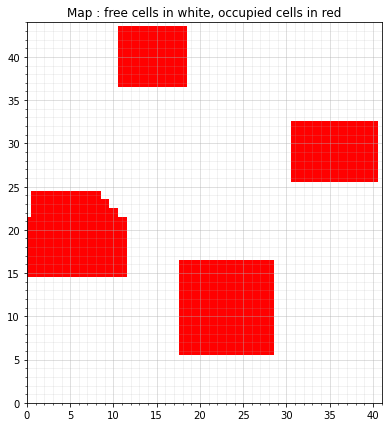

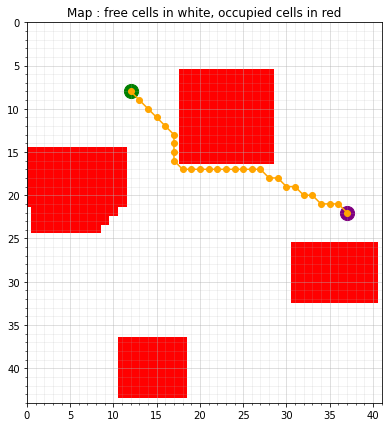

In [51]:
#init value for value setting
color_treshold = 150
zero_init = 0
B, G, R = (0, 1, 2)
Border = 0
goal, thymio = (0, 1)
x, y = (0, 1)

#constants
LOCALIZATION = 0
OCCUPANCY = 1
FREE = 0
OCCUPIED = 1

#####################################
#dans prog tif passer de 45 a 44 et 42 a 41?
#####################################
#shapren parameter
alpha = 1.5 # Contrast control (1.0-3.0)
beta = 0 # Brightness control (0-100)

#open image
image = cv2.imread('images/mapf.png')

object_grid, occupancy_grid, world = vision(image)

#change to the right coordinate format
occupancy_grid = (np.flipud(occupancy_grid)).transpose()
#display_map(occupancy_grid.transpose(), OCCUPANCY)

#thymio and goal coordinate
thymio_x = object_grid[thymio][y]
thymio_y = 44-object_grid[thymio][x]
goal_x = object_grid[goal][y]
goal_y = 44-object_grid[goal][x]

start = (thymio_x,thymio_y)
goal = (goal_x,goal_y)

final_occupancy_grid = increased_obstacles_map(occupancy_grid)

# Run the A* algorithm    
path = A_Star(start, goal, final_occupancy_grid)
path = np.array(path).reshape(-1, 2).transpose()
#display_map(final_occupancy_grid.transpose(), OCCUPANCY)
#plt.imshow(np.flipud(world[:,:,::-1]))
display_map(final_occupancy_grid.transpose(), OCCUPANCY)
display_global_path(start, goal, path, final_occupancy_grid.transpose())

#plt.imshow(np.flipud(world[:,:,::-1]))
